# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import numpy as np
from scipy import signal
import xarray as xr
from scipy.fft import fft, ifft

from src.utils.dataset_utils import *
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.utils.frequency_utils import *
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_nmf_event_composition, plot_avg_component_weight, plot_component_distribution

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Load data

In [5]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

#dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=fpa_identifiers,
#                                       dataset_path=dataset_path_2EE,
#                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

# FFT Analysis

In [6]:
dataset_1EE_detrend = dataset_creator_1EE.detrend_dim(dataset_1EE)
#dataset_2EE_detrend = dataset_creator_2EE.detrend_dim(dataset_2EE)

f_window=np.hamming
f_lim=(0, 500)
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE_detrend.data, f_window=f_window, f_lim=f_lim)
#dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE_detrend.data, f_window=f_window)

dataset_1EE_ifft = get_ifft_of_DataArray(data=dataset_1EE_fft, f_window=f_window)
#dataset_2EE_ifft = get_ifft_of_DataArray(data=dataset_2EE_fft, f_window=f_window)

dataset_1EE_fft_amplitude = scale_fft_amplitude(data=dataset_1EE_fft, f_window=f_window)
#dataset_2EE_fft_amplitude = scale_fft_amplitude(data=dataset_2EE_fft, f_window=f_window)

In [7]:
dataset_1EE_fft_real= scale_fft_amplitude(data=dataset_1EE_fft_amplitude, f_window=f_window, is_polar=True)
_ , dataset_1EE_fft_phase = complex_to_polar(dataset_1EE_fft)

dataset_1EE_fft2 = polar_to_complex(dataset_1EE_fft_real, dataset_1EE_fft_phase)
dataset_1EE_ifft2 = get_ifft_of_DataArray(data=dataset_1EE_fft2, f_window=f_window)

array(False)

# Calculate fft loss

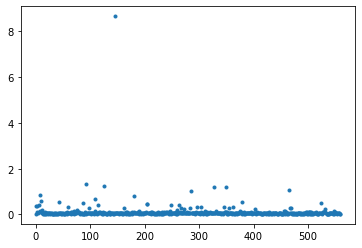

In [8]:
fft_loss_sample = dataset_1EE_detrend.data.values - np.real(dataset_1EE_ifft).values
fft_loss = np.linalg.norm(np.nan_to_num(fft_loss_sample[:,:,1:-1]), axis=(1,2))
plt.plot(np.abs(fft_loss), ".")

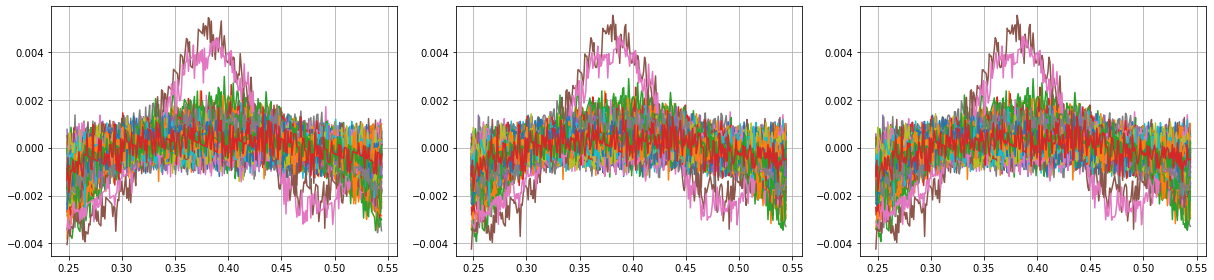

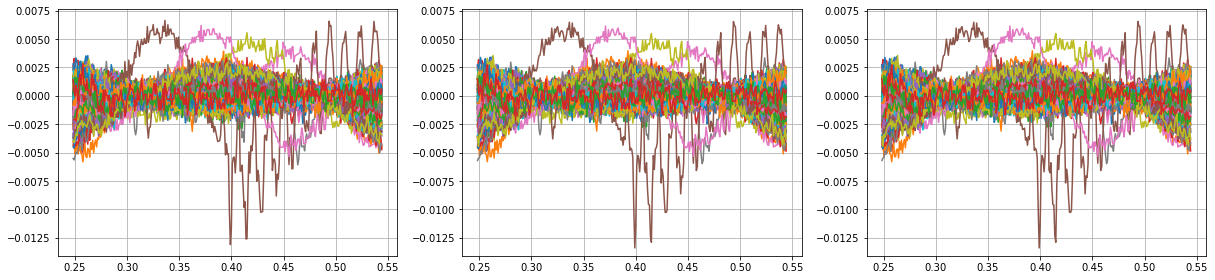

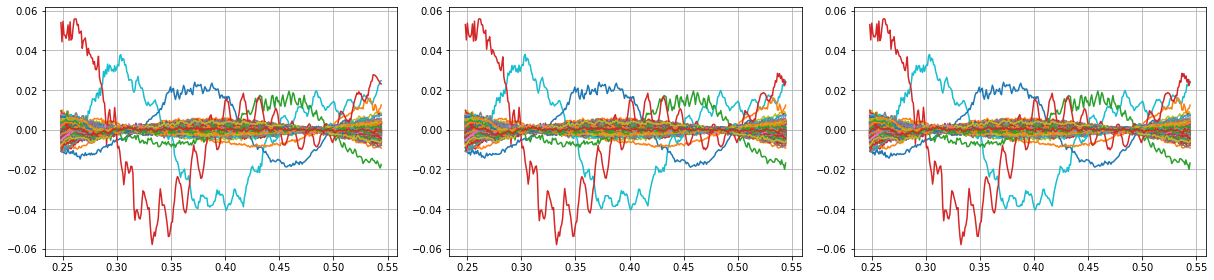

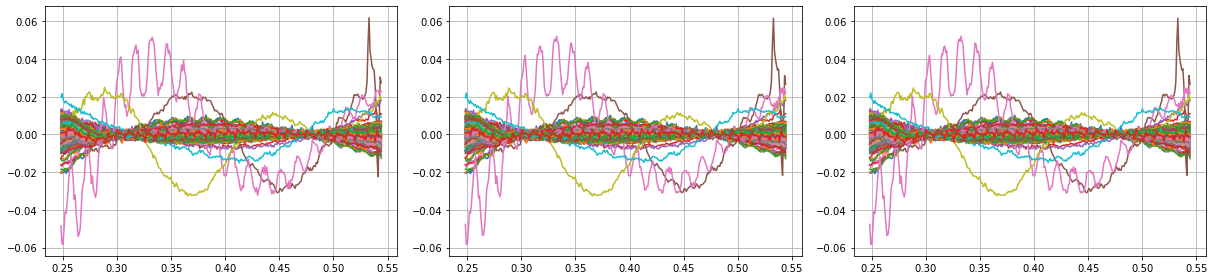

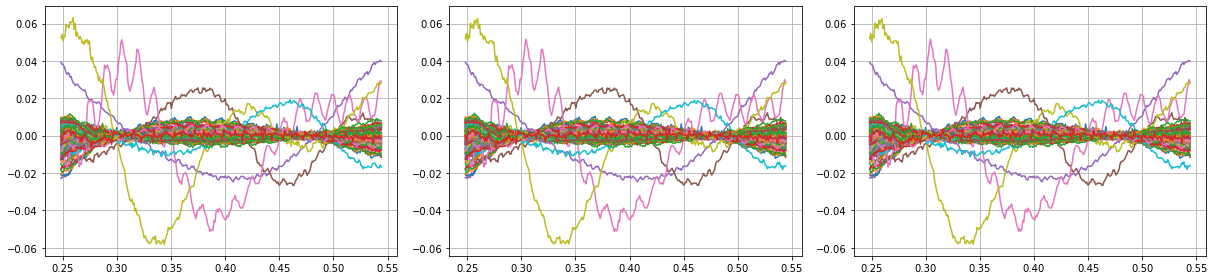

In [9]:
fft_outlier_idx = np.argsort(np.abs(fft_loss))

n_plots = 5
for i in fft_outlier_idx[:n_plots]:
    fig, ax = plt.subplots(1,3, figsize =(17,4))
    ax[0].plot(dataset_1EE_detrend.time, dataset_1EE_detrend.data[i].T)
    ax[0].grid()
    

    ax[1].plot(dataset_1EE_detrend.time, np.real(dataset_1EE_ifft[i].T))
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].grid()
    
    ax[2].plot(dataset_1EE_detrend.time, dataset_1EE_ifft2[i].T)
    ax[2].set_ylim(ax[0].get_ylim())
    ax[2].grid()
    
    
    #ax[2].plot(dataset_1EE_fft_amplitude.frequency, dataset_1EE_fft_amplitude[i].T)
    #ax[2].set_ylim(ax[1].get_ylim())
    #ax[2].set_xlim(f_lim)
    #ax[2].grid()

    plt.tight_layout()

# Test differtent window functions

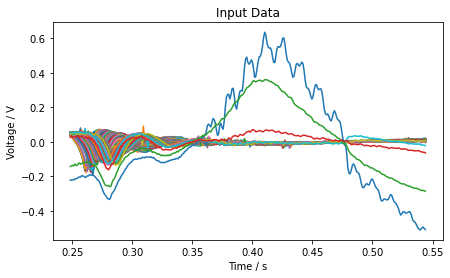

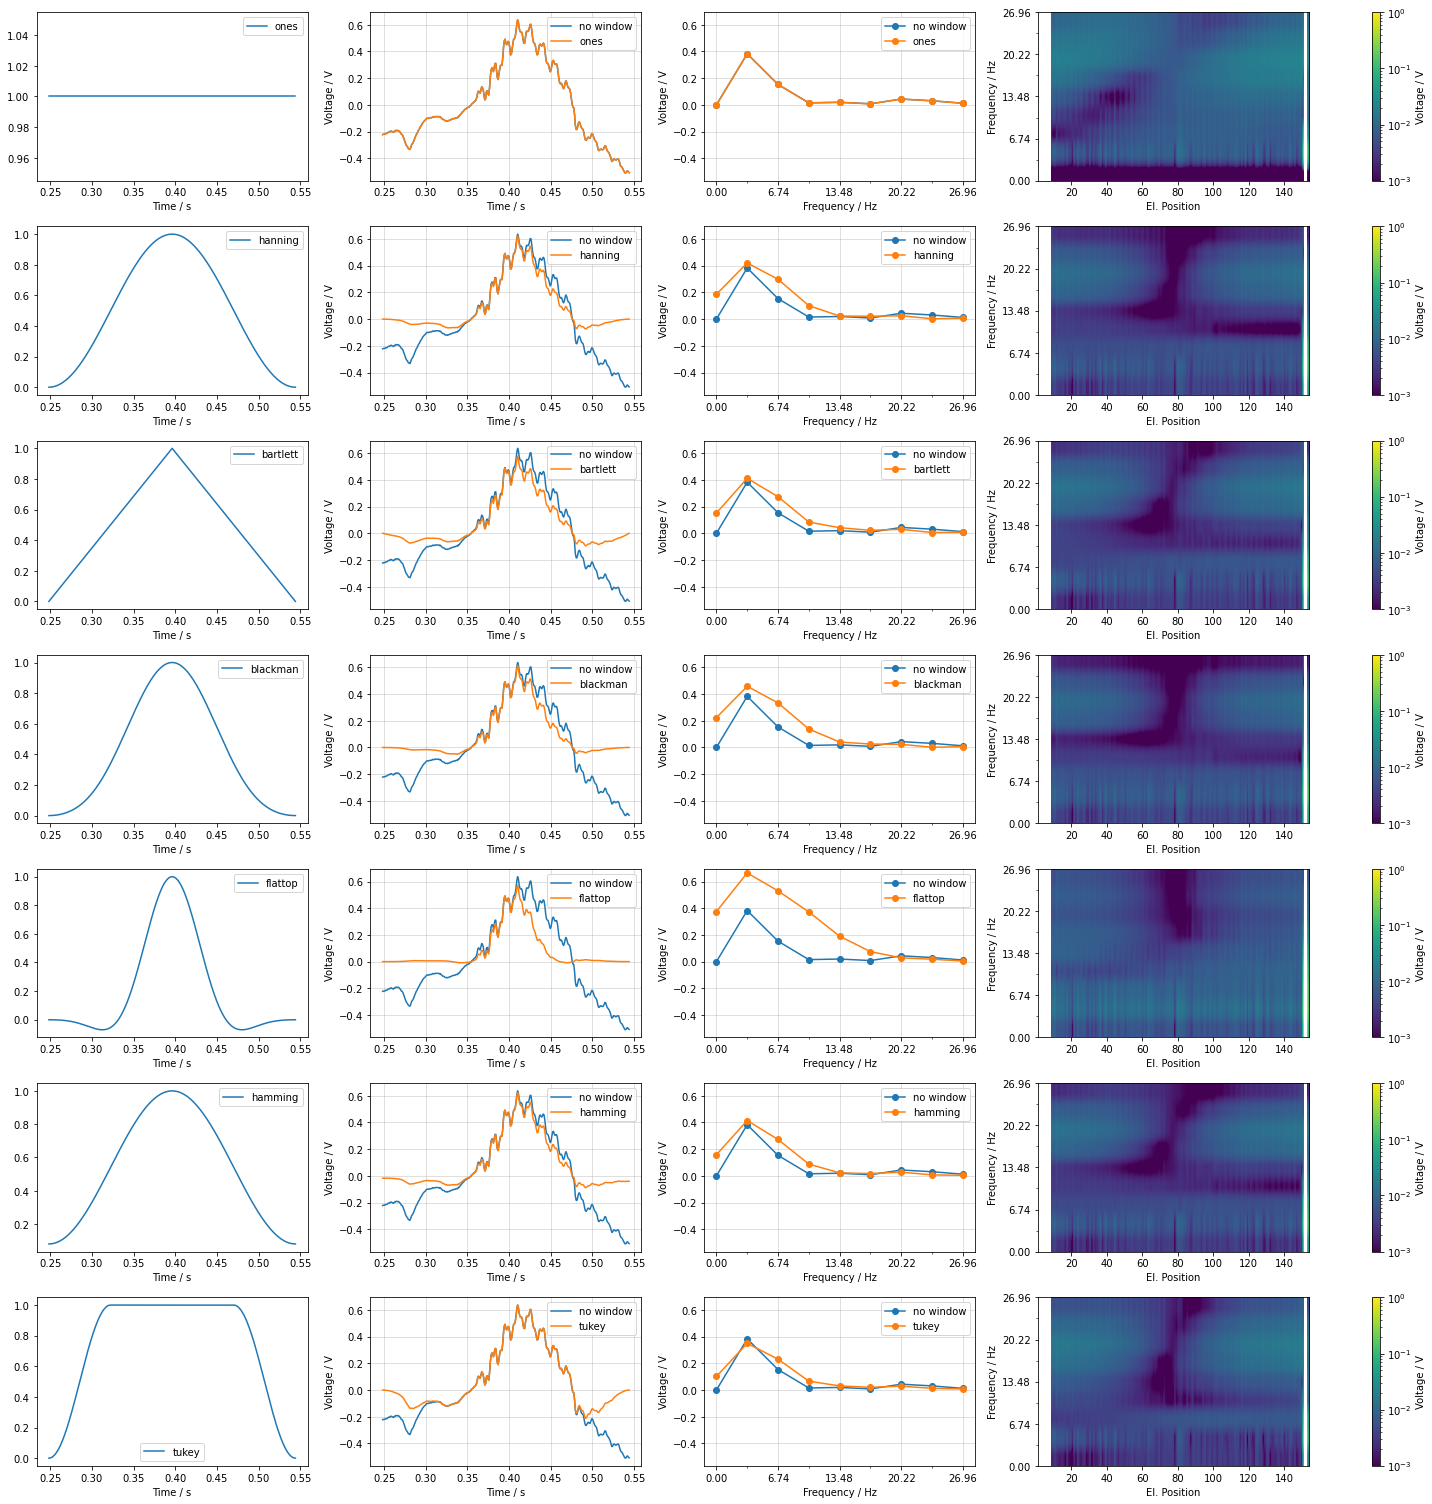

In [35]:
event = 2
magnet = 150
vmin = 1e-3
vmax = 1
max_freq = 30
data = dataset_1EE_detrend.data
fft_windows = [np.ones, np.hanning, signal.windows.bartlett, signal.windows.blackman, signal.windows.flattop, signal.windows.hamming, signal.windows.tukey]   

fig, ax = plt.subplots( figsize=(7, 4))
ax.plot(data.time, data[event].T)
ax.set_title("Input Data")
ax.set_ylabel('Voltage / V')
ax.set_xlabel('Time / s')
plt.show()

dataset_1EE_fft_nowin = get_fft_of_DataArray(data=data.isel(event=[event]), f_window=np.ones)
amplitude_nowin = scale_fft_amplitude(data=dataset_1EE_fft_nowin, f_window=np.ones)
amplitude_nowin = amplitude_nowin.where(amplitude_nowin.frequency < max_freq, drop=True)

fig, ax = plt.subplots(len(fft_windows),5, figsize = (20,3 * len(fft_windows)), gridspec_kw={'width_ratios': [4, 4, 4, 4, 0.5]})
for i, f_window in enumerate(fft_windows):
    dataset_1EE_fft_event = get_fft_of_DataArray(data=data.isel(event=[event]), f_window=f_window)
    amplitude = scale_fft_amplitude(data=dataset_1EE_fft_event, f_window=f_window)
    
    amplitude = amplitude.where(amplitude_nowin.frequency < max_freq, drop=True)
    
    window = f_window(len(data[event, magnet,:]))
    
    
    ax[i, 0].plot(data.time, window, label=f_window.__name__)
    ax[i, 0].set_xlabel('Time / s')
    ax[i, 0].legend()
    
    ax[i, 1].plot(data.time, data[event, magnet], label="no window")
    ax[i, 1].plot(data.time, data[event, magnet] * window, label=f_window.__name__)
    ax[i, 1].set_xlabel('Time / s')
    ax[i, 1].set_ylabel('Voltage / V')
    ax[i, 1].legend()
    ax[i, 1].grid(alpha=0.5)  
    

    ax[i, 2].plot(amplitude.frequency, amplitude_nowin[0, magnet], "-o", label="no window")
    ax[i, 2].plot(amplitude.frequency, amplitude[0, magnet], "-o", label=f_window.__name__)
    ax[i, 2].set_xlabel('Frequency / Hz')
    ax[i, 2].set_ylabel('Voltage / V')
    ax[i, 2].legend()
    ax[i, 2].set_xticks(amplitude.frequency.values, minor=True)
    ax[i, 2].set_xticks(amplitude.frequency.values[::2])
    ax[i, 2].grid(alpha=0.5)  
    ax[i, 2].set_ylim(ax[i, 1].get_ylim())  
    
    im = plot_position_frequency_map(ax[i, 3], amplitude, amplitude.frequency, vmin=vmin, vmax=vmax)
    ax[i, 3].set_ylabel('Frequency / Hz')
    ax[i, 3].set_xlabel('El. Position')
    ax[i, 3].set_yticks(amplitude.frequency.values, minor=True)
    ax[i, 3].set_yticks(amplitude.frequency.values[::2])

    cbar = fig.colorbar(im, ax=ax[i, 4], fraction=1)
    ax[i, 4].set_axis_off()
    cbar.set_label('Voltage / V')
    plt.tight_layout()

# Check Amplitudes

In [ ]:
def plot_time_fft_comparison(data, data_fft, dataset_ifft):
    fig, ax = plt.subplots(1,2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 0.3]})

    ax[0].plot(data.time, data, label="signal")
    ax[0].plot(data.time, np.real(dataset_ifft), label="reconstruction")
    ax[0].plot(data.time, np.imag(dataset_ifft), label="imag")
    ax[0].plot(data.time, np.abs(dataset_ifft), label="real")
    ax[0].legend()
    
    ax[1].plot(data_fft.frequency, data_fft.data, "-o")
    mean_amplitude = np.nanmean(np.abs(dataset_ifft.values[1:-1]))
    ax[1].plot(data_fft.frequency, np.ones(len(data_fft.frequency)) * mean_amplitude)
    
    

    ax[0].grid()
    ax[1].grid()

    ax[0].set_title("time-series")
    ax[1].set_title("frequency")

    ax[0].set_xlim((data.time[0], data.time[-1]))
    ax[0].set_xticks(np.arange(np.round(data.time[0].values, 2), np.round(data.time[-1].values, 2), 0.02))

    ax[1].set_xlim((data_fft.frequency[0], data_fft.frequency[-1]))
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_xticks(data_fft.frequency.values[::3].astype(int))
    ax[1].set_xlim((0,100))

    plt.tight_layout()
    plt.show()

In [ ]:
for i in np.arange(46,47):    
    fig, ax = plt.subplots( figsize=(12, 5))
    ax.plot(dataset_2EE.time, dataset_2EE.data[i].T)
    ax.set_title("Input Data")
    ax.set_ylabel('Voltage / V')
    ax.set_xlabel('Time / s')
    idx_larges_signal = np.nan_to_num(dataset_2EE.data[i].values).max(axis=1).argmax()
    ax.set_title(f"{i} , {idx_larges_signal}")
    plt.show()

In [ ]:
fpa_idx = "RB_RB.A45_1621314674500000000"
event = np.arange(len(dataset_1EE.event))[dataset_1EE.event == fpa_idx][0]
magnet = 35

plot_time_fft_comparison(dataset_1EE_detrend.data[event,magnet], dataset_1EE_fft_amplitude[event,magnet], dataset_1EE_ifft[event,magnet])

In [ ]:
event = 46
magnet = 44 
plot_time_fft_comparison(dataset_2EE_detrend.data[event,magnet], dataset_2EE_fft_amplitude[event,magnet], dataset_2EE_ifft[event,magnet])